# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy
from scipy import integrate
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os

from matplotlib.patches import Rectangle


In [4]:
sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot
import akta

# Optimized HCCF fractionation

In [39]:
files = os.listdir('./data/')
files.sort()
files = [f for f in files if '2022 03 05' in f or '2022 03 06' in f]

In [40]:
dfs = {}
for f in files:
    dfs[f] = akta.load_and_clean_xls(f'./data/{f}')

dfs[files[0]]['run'] = 1
dfs[files[0]] = dfs[files[0]][dfs[files[0]]['uv_280_ml'].notna()].copy()
v_max_1 = max(dfs[files[0]].uv_280_ml)

dfs[files[1]].uv_280_ml += v_max_1
dfs[files[1]].fractions_ml += v_max_1
dfs[files[1]].inject_ml += v_max_1
dfs[files[1]] = dfs[files[1]][dfs[files[1]]['uv_280_ml'].notna()].copy()
dfs[files[1]]['run'] = 2

df = pd.concat([dfs[files[0]], dfs[files[1]]], ignore_index=True)

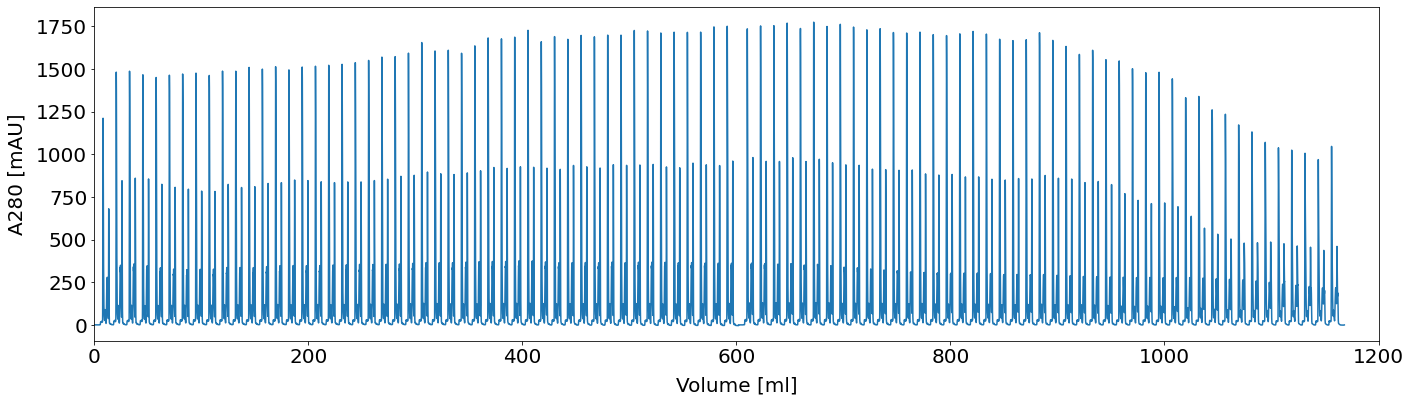

In [41]:
fig, ax = my_plot.instantiate_fig(x=20, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')
ax.plot(df.uv_280_ml, df.uv_280_mAU)
# my_plot.add_fractions(ax, df, x_conversion=1, text=False, xlim_times=None, ylim_min=None)
ax.set_xlim(0, 1200)
my_plot.set_layout(fig, ax)
# fig.savefig('./images/HCCF_optimized_1.png', dpi=300)

In [42]:
v_inj = df.inject_ml[df.inject_ml.notna()].values
cycle_nums = {}
for i, v in enumerate(v_inj):
    cycle_nums[v] = i
    
cycles = []
for i, cont in df.iterrows():
    v = v_inj[v_inj - cont.uv_280_ml <= 0][-1]
    cycles.append(cycle_nums[v])
df['cycle'] = cycles

offset = 5.0
for i, v in enumerate(v_inj):
    indeces = df[df.cycle==i].index
    vals = df[df.cycle==i].uv_280_ml.values
    df.loc[indeces, 'cycle_ml'] = vals - v

for i, v in enumerate(v_inj):
    indeces = df[((df.cycle==i) & (df.cycle_ml > offset)) | ((df.cycle==i+1) & (df.cycle_ml < offset))].index
    vals = df[((df.cycle==i) & (df.cycle_ml > offset)) | ((df.cycle==i+1) & (df.cycle_ml < offset))].uv_280_ml.values
    df.loc[indeces, 'cycle_decon'] = i
    df.loc[indeces, 'cycle_decon_ml'] = vals - (v + offset)
    

In [43]:
df_hccf_all_fracs = akta.load_and_clean_xls('./data/CH 2022 03 09 pseudo preparative sec HCCF CB all fracs 2 07.xls')

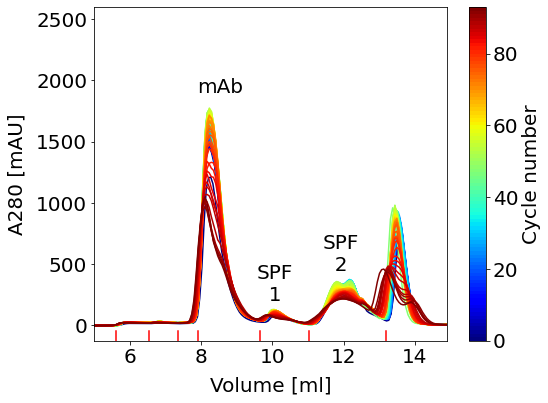

In [44]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
    
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj)), cmap=cmap), ax=ax)
cbar.set_label('Cycle number')
for v in df_hccf_all_fracs[:8].fractions_ml:
    ax.axvline(v, ymin=0, ymax=0.03, color='red')

ax.set_xlim(offset, 14.9)
ax.set_ylim(-125, 2600)
ax.annotate('mAb', xytext=(7.9, 1900), xy=(6, 0.05), fontsize=20)
ax.annotate('SPF\n  1', xytext=(9.55, 200), xy=(6, 0.05), fontsize=20)
ax.annotate('SPF\n  2', xytext=(11.4, 450), xy=(6, 0.05), fontsize=20)

# ax.annotate('mAb', xytext=(8.5, 1500), xy=(6, 0.05), fontsize=18)
# ax.annotate('SPF 1', xytext=(9.55, 200), xy=(6, 0.05), fontsize=18)
# ax.annotate('SPF 2', xytext=(11.3, 450), xy=(6, 0.05), fontsize=18)
# ax.annotate('LMW\n   3', xytext=(12.8, 1050), xy=(6, 0.05), fontsize=18)

# ax.add_patch(Rectangle((5.1, -5), 8.0-5.1, 45+5, fill=False, edgecolor='black', lw=1.25))

my_plot.set_layout(fig, ax)
# fig.savefig('./images/HCCF_optimized_1_overlay.png', dpi=300)
fig.savefig('./images/HCCF_full.png', dpi=300, bbox_inches='tight')

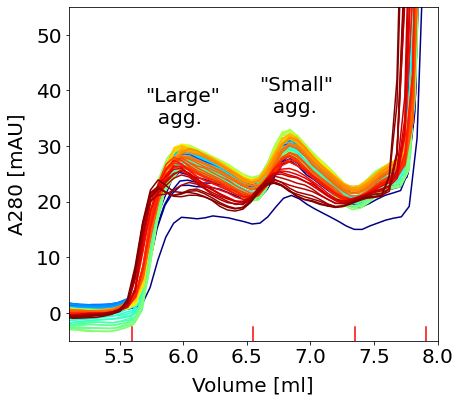

In [45]:
fig, ax = my_plot.instantiate_fig(x=6.8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))

for v in df_hccf_all_fracs[:8].fractions_ml:
    ax.axvline(v, ymin=0, ymax=0.04, color='red')

ax.set_xlim(5.1, 8.0)
ax.set_ylim(-5, 55)
ax.annotate('"Large"\n  agg.', xytext=(5.7, 34), xy=(6, 0.05), fontsize=20)
ax.annotate('"Small"\n  agg.', xytext=(6.6, 36), xy=(6, 0.05), fontsize=20)

# ax.set_xlim(5.1, 8.0)
# ax.set_ylim(-5, 45)
# ax.annotate('"Large"\n  agg.', xytext=(5.8, 34), xy=(6, 0.05), fontsize=18)
# ax.annotate('"Small"\n  agg.', xytext=(6.65, 36), xy=(6, 0.05), fontsize=18)

my_plot.set_layout(fig, ax)
# fig.savefig('./images/HCCF_optimized_1_overlay_zoomed.png', dpi=300)
fig.savefig('./images/HCCF_magnified.png', dpi=300, bbox_inches='tight')

Text(11.4, 450, 'SPF\n  2')

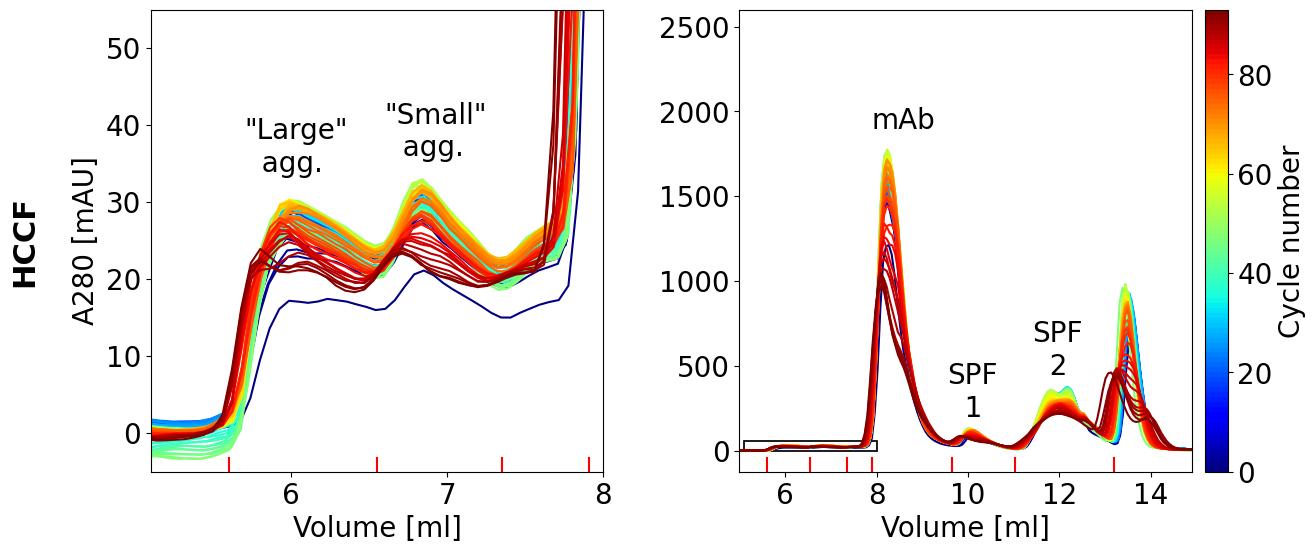

In [13]:
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(16, 6, forward=True)
for i in [0, 1]:
    ax[i].set_xlabel('Volume [ml]')
ax[0].set_ylabel('A280 [mAU]')

ax[0].set_xlim(5.1, 8.0)
ax[0].set_ylim(-5, 55)
ax[1].set_xlim(offset, 14.9)
ax[1].set_ylim(-125, 2600)

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    for j in [0, 1]:
        ax[j].plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
    
for v in df_hccf_all_fracs[:8].fractions_ml:
    for j in [0, 1]:
        ax[j].axvline(v, ymin=0, ymax=0.03, color='red')
    
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj)), cmap=cmap), ax=ax, pad=0.01)
cbar.set_label('Cycle number')

ax[0].annotate('HCCF', xytext=(4.2, 25), xy=(6, 0.05), fontsize=22, rotation=90, weight='bold', va='center')
ax[0].annotate('"Large"\n  agg.', xytext=(5.7, 34), xy=(6, 0.05), fontsize=20)
ax[0].annotate('"Small"\n  agg.', xytext=(6.6, 36), xy=(6, 0.05), fontsize=20)

ax[1].add_patch(Rectangle((5.1, -5), 8.0-5.1, 55+5, fill=False, edgecolor='black', lw=1.25))
ax[1].annotate('mAb', xytext=(7.9, 1900), xy=(6, 0.05), fontsize=20)
ax[1].annotate('SPF\n  1', xytext=(9.55, 200), xy=(6, 0.05), fontsize=20)
ax[1].annotate('SPF\n  2', xytext=(11.4, 450), xy=(6, 0.05), fontsize=20)

# fig.savefig('./images/HCCF_optimized_1_overlay_subfigures.png', dpi=300, bbox_inches='tight')

In [20]:
df_hccf = df.copy()

In [21]:
files = os.listdir('./data/')
files = [f for f in files if '2022 03 09' in f]
files = [f for f in files if 'HCCF' in f]
files.sort()
files

['CH 2022 03 09 pseudo preparative sec HCCF CB all fracs 1 02.xls',
 'CH 2022 03 09 pseudo preparative sec HCCF CB all fracs 2 07.xls',
 'CH 2022 03 09 pseudo preparative sec HCCF CB all fracs 3 05.xls']

In [22]:
dfs = {}
for i, f in enumerate(files):
    dfs[f] = akta.load_and_clean_xls(f'./data/{f}')
    dfs[f]['run'] = i
    dfs[f] = dfs[f][dfs[f].uv_280_ml.notna()].copy()
    
    if i == 0:
        df_regen = dfs[f].copy()
    else:
        dfs[f].uv_280_ml    += v_max
        dfs[f].fractions_ml += v_max
        dfs[f].inject_ml    += v_max
        df_regen = pd.concat([df_regen, dfs[f]], ignore_index=True)
    
    v_max = df_regen.uv_280_ml.max()

WARNING *** file size (2446474) not 512 + multiple of sector size (512)


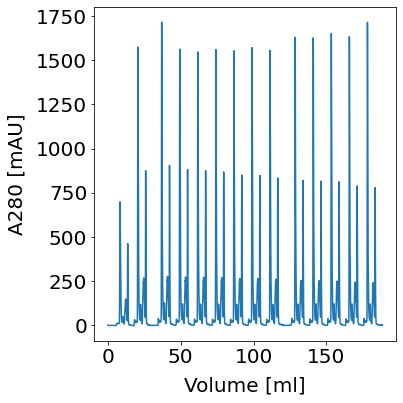

In [23]:
fig, ax = my_plot.instantiate_fig(x=6, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')
ax.plot(df_regen.uv_280_ml, df_regen.uv_280_mAU)
# my_plot.add_fractions(ax, df, x_conversion=1, text=False, xlim_times=None, ylim_min=None)
# ax.set_xlim(0, 1200)
my_plot.set_layout(fig, ax)
# fig.savefig('./images/HCCF_regen.png', dpi=300)

In [24]:
v_inj_regen = df_regen.inject_ml[df_regen.inject_ml.notna()].values
cycle_nums = {}
for i, v in enumerate(v_inj_regen):
    cycle_nums[v] = i
    
cycles = []
for i, cont in df_regen.iterrows():
    v = v_inj_regen[v_inj_regen - cont.uv_280_ml <= 0][-1]
    cycles.append(cycle_nums[v])
df_regen['cycle'] = cycles

offset = 5.0
for i, v in enumerate(v_inj_regen):
    indeces = df_regen[df_regen.cycle==i].index
    vals = df_regen[df_regen.cycle==i].uv_280_ml.values
    df_regen.loc[indeces, 'cycle_ml'] = vals - v

for i, v in enumerate(v_inj_regen):
    indeces = df_regen[((df_regen.cycle==i) & (df_regen.cycle_ml > offset)) | ((df_regen.cycle==i+1) & (df_regen.cycle_ml < offset))].index
    vals = df_regen[((df_regen.cycle==i) & (df_regen.cycle_ml > offset)) | ((df_regen.cycle==i+1) & (df_regen.cycle_ml < offset))].uv_280_ml.values
    df_regen.loc[indeces, 'cycle_decon'] = i
    df_regen.loc[indeces, 'cycle_decon_ml'] = vals - (v + offset)
    

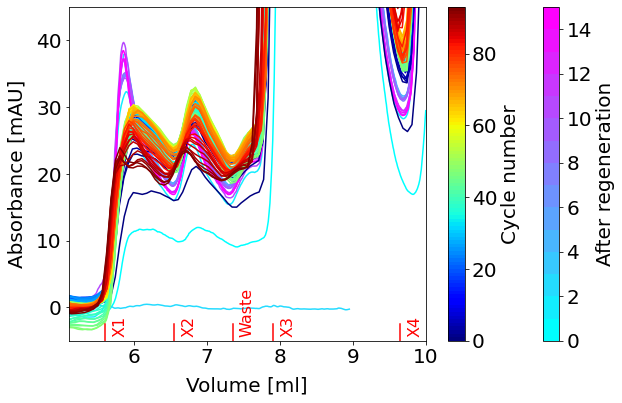

In [25]:
fig, ax = my_plot.instantiate_fig(x=9.2, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

cmap = plt.get_cmap('cool', lut=len(v_inj_regen))
for i in range(len(v_inj_regen)):
    df_temp = df_regen[df_regen.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj_regen)), cmap=cmap), ax=ax)
cbar.set_label('After regeneration')

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj)), cmap=cmap), ax=ax)
cbar.set_label('Cycle number')

# ax.set_xlim(offset, 18)
# my_plot.set_layout(fig, ax)
# fig.savefig('./images/HCCF_regen_overlay.png', dpi=300)

ax.set_xlim(5.1, 10)
ax.set_ylim(-5, 45)
my_plot.add_fractions(ax, df_regen[:6], text=True, xlim_times=(5, 10), hide_waste=False, text_offset=0.1, text_size=16)
my_plot.set_layout(fig, ax)
# fig.savefig('./images/HCCF_regen_overlay_zoomed.png', dpi=300)

# PAFVIN

In [26]:
files = os.listdir('./data/')
files.sort()
# files = [f for f in files if '2022 03 09' in f or '2022 03 10' in f or '2022 03 11' in f]
files = [f for f in files if '2022 03 10' in f or '2022 03 11' in f]
files = [f for f in files if 'PAFVIN' in f]
files

['CH 2022 03 10 pseudo preparative sec PAFVIN mod 1 40.xls',
 'CH 2022 03 10 pseudo preparative sec PAFVIN mod 2 03.xls',
 'CH 2022 03 10 pseudo preparative sec PAFVIN mod 3 50.xls',
 'CH 2022 03 10 pseudo preparative sec PAFVIN mod 4 50.xls',
 'CH 2022 03 11 pseudo preparative sec PAFVIN mod 1 28.xls']

In [27]:
dfs = {}
for i, f in enumerate(files):
    dfs[f] = akta.load_and_clean_xls(f'./data/{f}')
    dfs[f]['run'] = i
    dfs[f] = dfs[f][dfs[f].uv_280_ml.notna()].copy()
    
    if i == 0:
        df = dfs[f].copy()
    else:
        dfs[f].uv_280_ml    += v_max
        dfs[f].fractions_ml += v_max
        dfs[f].inject_ml    += v_max
        df = pd.concat([df, dfs[f]], ignore_index=True)
    
    v_max = df.uv_280_ml.max()

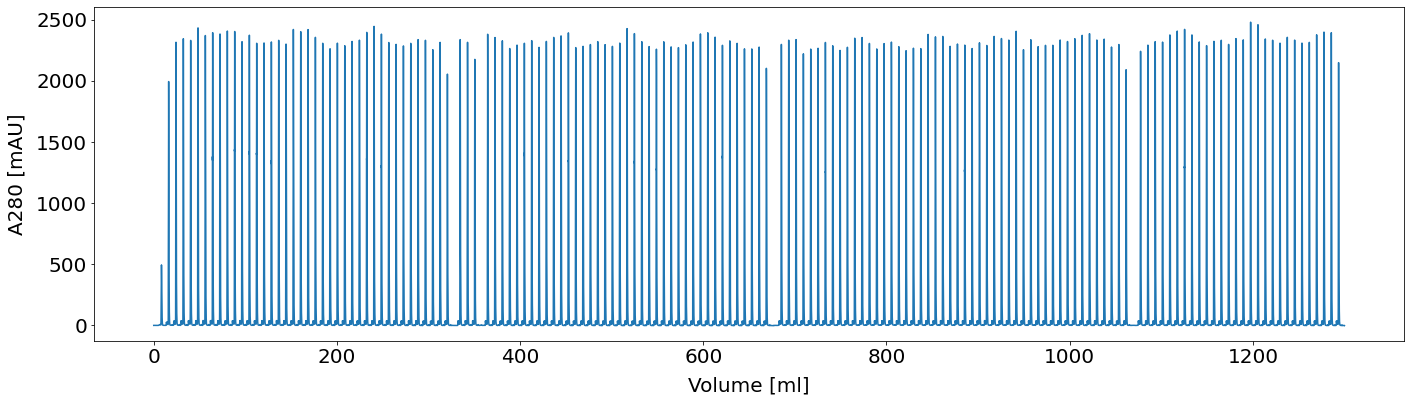

In [28]:
fig, ax = my_plot.instantiate_fig(x=20, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')
ax.plot(df.uv_280_ml, df.uv_280_mAU)
# my_plot.add_fractions(ax, df, x_conversion=1, text=False, xlim_times=None, ylim_min=None)
# ax.set_xlim(0, 1200)
my_plot.set_layout(fig, ax)
# fig.savefig('./images/PAFVIN_optimized.png', dpi=300)

In [29]:
v_inj = df.inject_ml[df.inject_ml.notna()].values
cycle_nums = {}
for i, v in enumerate(v_inj):
    cycle_nums[v] = i
    
cycles = []
for i, cont in df.iterrows():
    v = v_inj[v_inj - cont.uv_280_ml <= 0][-1]
    cycles.append(cycle_nums[v])
df['cycle'] = cycles

offset = 5.0
for i, v in enumerate(v_inj):
    indeces = df[df.cycle==i].index
    vals = df[df.cycle==i].uv_280_ml.values
    df.loc[indeces, 'cycle_ml'] = vals - v

for i, v in enumerate(v_inj):
    indeces = df[((df.cycle==i) & (df.cycle_ml > offset)) | ((df.cycle==i+1) & (df.cycle_ml < offset))].index
    vals = df[((df.cycle==i) & (df.cycle_ml > offset)) | ((df.cycle==i+1) & (df.cycle_ml < offset))].uv_280_ml.values
    df.loc[indeces, 'cycle_decon'] = i
    df.loc[indeces, 'cycle_decon_ml'] = vals - (v + offset)
    

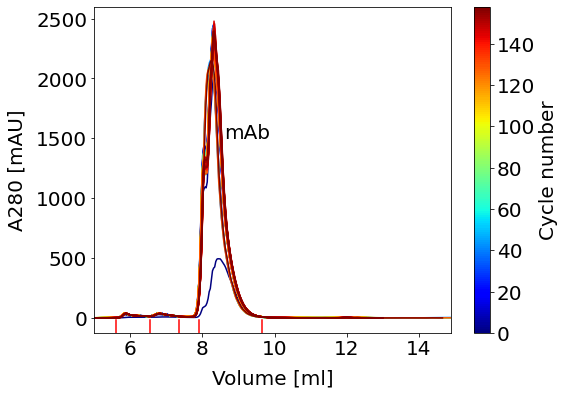

In [37]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
    
for v in df_hccf_all_fracs[:5].fractions_ml:
    ax.axvline(v, ymin=0, ymax=0.04, color='red')
    
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj)), cmap=cmap), ax=ax)
cbar.set_label('Cycle number')

ax.set_xlim(offset, 14.9)
ax.set_ylim(-125, 2600)
ax.annotate('mAb', xytext=(8.6, 1500), xy=(6, 0.05), fontsize=20)

fig.savefig('./images/PAVIN_full.png', dpi=300, bbox_inches='tight')

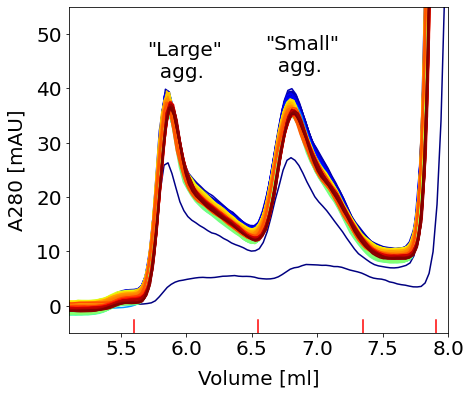

In [38]:
fig, ax = my_plot.instantiate_fig(x=6.8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
    
for v in df_hccf_all_fracs[:5].fractions_ml:
    ax.axvline(v, ymin=0, ymax=0.04, color='red')

ax.set_xlim(5.1, 8.0)
ax.set_ylim(-5, 55)
ax.annotate('"Large"\n  agg.', xytext=(5.7, 42), xy=(6, 0.05), fontsize=20)
ax.annotate('"Small"\n  agg.', xytext=(6.6, 43), xy=(6, 0.05), fontsize=20)

fig.savefig('./images/PAVIN_magnified.png', dpi=300, bbox_inches='tight')

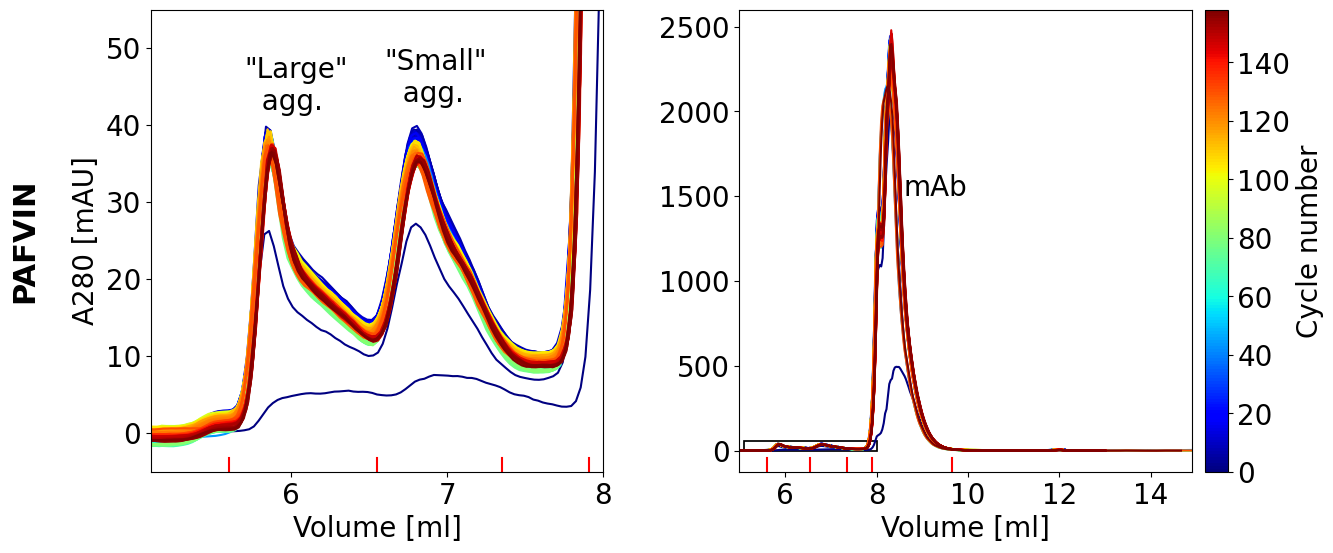

In [32]:
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(16, 6, forward=True)
for i in [0, 1]:
    ax[i].set_xlabel('Volume [ml]')
ax[0].set_ylabel('A280 [mAU]')

ax[0].set_xlim(5.1, 8.0)
ax[0].set_ylim(-5, 55)
ax[1].set_xlim(offset, 14.9)
ax[1].set_ylim(-125, 2600)

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    for j in [0, 1]:
        ax[j].plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
    
for v in df_hccf_all_fracs[:5].fractions_ml:
    for j in [0, 1]:
        ax[j].axvline(v, ymin=0, ymax=0.03, color='red')
    
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj)), cmap=cmap), ax=ax, pad=0.01)
cbar.set_label('Cycle number')

ax[0].annotate('PAFVIN', xytext=(4.2, 25), xy=(6, 0.05), fontsize=22, rotation=90, weight='bold', va='center')
ax[0].annotate('"Large"\n  agg.', xytext=(5.7, 42), xy=(6, 0.05), fontsize=20)
ax[0].annotate('"Small"\n  agg.', xytext=(6.6, 43), xy=(6, 0.05), fontsize=20)

ax[1].add_patch(Rectangle((5.1, -5), 8.0-5.1, 55+5, fill=False, edgecolor='black', lw=1.25))
ax[1].annotate('mAb', xytext=(8.6, 1500), xy=(6, 0.05), fontsize=20)

# fig.savefig('./images/PAFVIN_optimized_1_overlay_subfigures.png', dpi=300, bbox_inches='tight')

# HCCF vs PAFVIN

### Concentrated HCCF

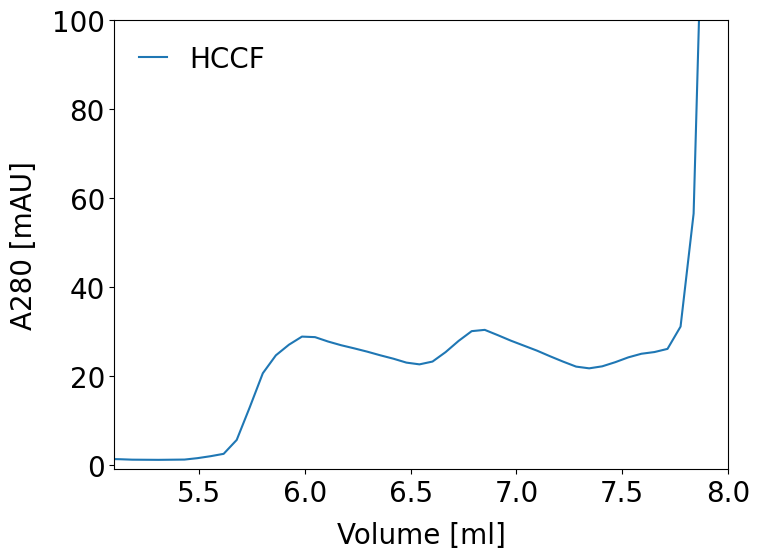

In [34]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')

cycle = 11
df_temp = df_hccf[df_hccf.cycle_decon == cycle]
ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, label='HCCF')
# df_temp = df_pafvin[df_pafvin.cycle_decon == cycle]
# ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, label='PAFVIN')

# ax.set_xlim(5, 15)
# ax.set_ylim(-50, 2500)
# my_plot.set_layout(fig, ax, legend=True)
# fig.savefig(f'./images/HCCF_vs_PAFVIN_cycle_{cycle}.png', dpi=300)

ax.set_xlim(5.1, 8)
ax.set_ylim(-1, 100)
my_plot.set_layout(fig, ax, legend=True)
# fig.savefig(f'./images/HCCF_vs_PAFVIN_cycle_{cycle}_zoomed.png', dpi=300)

### Unconcentrated HCCF

In [35]:
df_hccf_unc = akta.read_data_normalized(f'./data/CH 2022 02 02 pseudo preparative sec mAb 4 HCCF CB unconcentrated dev 1.xls')
flow = 0.6 # ml/min
df_hccf_unc['volume_ml'] = df_hccf_unc.time_min * flow

In [36]:
df_hccf_unc

,time_min,uv_280_mAU,uv_295_mAU,cond_mS_cm,tis_mM,volume_ml
0,0,0.244,0.164,12.864,145.956603,0.0
1,0.006667,0.246,0.156,12.864,145.956603,0.004
2,0.013333,0.252,0.141,12.864,145.956603,0.008
3,0.02,0.248,0.138,12.864,145.956603,0.012
4,0.026667,0.251,0.141,12.8642,145.958601,0.016
...,...,...,...,...,...,...
6823,45.486667,1.404,0.737,12.882,146.136425,27.292
6824,45.493334,1.407,0.743,12.882,146.136425,27.296
6825,45.500001,1.401,0.744,12.882,146.136425,27.3
6826,45.506667,1.39,0.748,12.882,146.136425,27.304


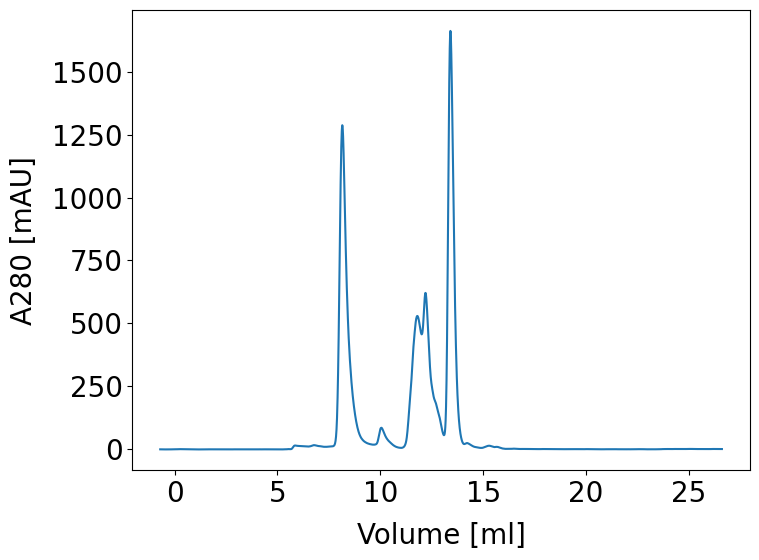

In [38]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')

shift = 0.7
ax.plot(df_hccf_unc.volume_ml - shift, df_hccf_unc.uv_280_mAU, label='HCCF')

cycle = 15
# df_temp = df_pafvin[df_pafvin.cycle_decon == cycle]
# ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, label='PAFVIN')

# ax.set_xlim(5, 15)
# ax.set_ylim(-50, 2800)
# my_plot.set_layout(fig, ax, legend=True)
# fig.savefig(f'./images/HCCF_vs_PAFVIN_cycle_{cycle}.png', dpi=300)

# ax.set_xlim(5.1, 7.8)
# ax.set_ylim(-1, 50)
my_plot.set_layout(fig, ax)
# fig.savefig(f'./images/HCCF_vs_PAFVIN_cycle_{cycle}_zoomed.png', dpi=300)